In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [47]:
# Data download
url = "https://www.dropbox.com/scl/fi/s96qd5tgr972wybd7z0n2/navier-stokes.npz?rlkey=8fw1kwnamcl2xaty57tnoau3e&st=rrfv05zm&dl=1"
filename = 'data/navier-stokes.npz'

from pathlib import Path
Path("data").mkdir(exist_ok=True)  # create 'data' folder

import os
if not os.path.exists(filename):
    # install and import wget library to download the data file
    !pip install wget
    import wget
    wget.download(url, filename)

In [48]:
with np.load(filename) as data:
    flow = data['flow']
    re = data['re']

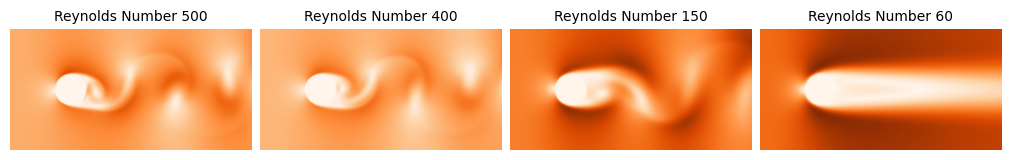

In [49]:
def visualize_flows(data, labels, cmap='RdYlBu', vmin=None, vmax=None):
    # Define the number of flows and time length
    C, T, _, _ = data.shape

    # Compute vmin and vmax per channel
    if vmin is None:
        vmin = data.min(axis=(1, 2, 3))  # Min for each channel
    if vmax is None:
        vmax = data.max(axis=(1, 2, 3))  # Max for each channel

    # Initialize figure and axes
    fig, axes = plt.subplots(1, C, figsize=(C * 2.5, 2.5), constrained_layout=True)

    if C == 1:
        axes = [axes]  # Ensure axes is iterable for a single-channel case

    # Display initial frame and set titles
    images = []
    for c, ax in enumerate(axes):
        images.append(ax.imshow(data[c, 0], cmap=cmap, vmin=vmin[c], vmax=vmax[c]))
        ax.set_title(labels[c], fontsize=10)
        ax.axis("off")

    # Animation update function
    def update(frame):
        """ Update function for animation. """
        for c in range(C):
            images[c].set_array(data[c, frame])
        return images

    # Set up animation
    ani = animation.FuncAnimation(fig, update, frames=T, interval=100, blit=False)

    # Display the animation
    return HTML(ani.to_jshtml())

I = np.arange(len(flow))
np.random.shuffle(I)
I = I[:4]
visualize_flows(flow[I,:,:,:], [f"Reynolds Number {re[i]}" for i in I], "Oranges")

In [50]:
# Train test split
train_indices = range(4, len(re)-5, 2)
test_indices = list(set(range(len(re))) - set(train_indices))
print(re[train_indices])
print(re[test_indices])

[  60  100  140  200  300  400  500  600  700  800  900 1000 3000 5000]
[   15    20    30    40    80   120   150   250   350   450   550   650
   750   850   950  2000  4000  6000  7000  8000  9000 10000]


In [51]:
X_train = torch.Tensor(flow[train_indices,:,:,:])
Y_train = torch.Tensor(re[train_indices])

X_test = torch.Tensor(flow[test_indices,:,:,:])
Y_test = torch.Tensor(re[test_indices])

Epoch [1/30], Loss: 0.3006
Epoch [2/30], Loss: 0.0536
Epoch [3/30], Loss: 0.0305
Epoch [4/30], Loss: 0.0232
Epoch [5/30], Loss: 0.0163
Epoch [6/30], Loss: 0.0132
Epoch [7/30], Loss: 0.0070
Epoch [8/30], Loss: 0.0080
Epoch [9/30], Loss: 0.0062
Epoch [10/30], Loss: 0.0059
Epoch [11/30], Loss: 0.0114
Epoch [12/30], Loss: 0.0074
Epoch [13/30], Loss: 0.0072
Epoch [14/30], Loss: 0.0067
Epoch [15/30], Loss: 0.0076
Epoch [16/30], Loss: 0.0025
Epoch [17/30], Loss: 0.0047
Epoch [18/30], Loss: 0.0043
Epoch [19/30], Loss: 0.0077
Epoch [20/30], Loss: 0.0049
Epoch [21/30], Loss: 0.0026
Epoch [22/30], Loss: 0.0035
Epoch [23/30], Loss: 0.0054
Epoch [24/30], Loss: 0.0031
Epoch [25/30], Loss: 0.0024
Epoch [26/30], Loss: 0.0034
Epoch [27/30], Loss: 0.0023
Epoch [28/30], Loss: 0.0062
Epoch [29/30], Loss: 0.0029
Epoch [30/30], Loss: 0.0032


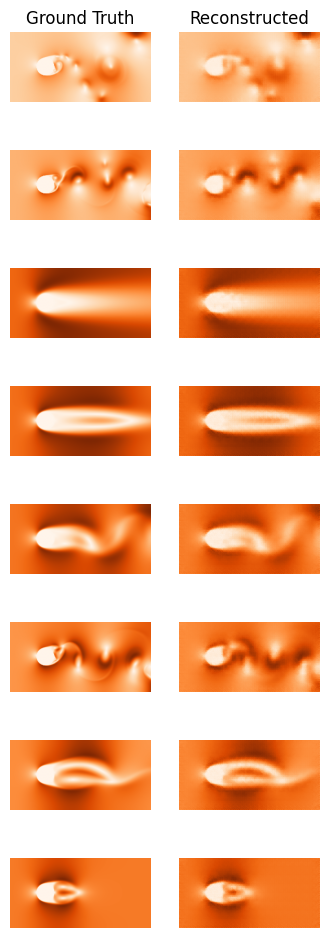

In [ ]:
# Define the Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



train_dataset = torch.utils.data.TensorDataset(X_train.flatten(0,1).unsqueeze(1))  # for AE, we ignore time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test.flatten(0,1).unsqueeze(1))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for images, in train_loader:
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = mse(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Visualizing results
def visualize_reconstruction(model, dataset):
    model.eval()
    images, = next(iter(dataset))
    images = images[:8].to(device)
    
    with torch.no_grad():
        reconstructions = model(images)
    
    _, axes = plt.subplots(8, 2, figsize=(4,12))
    for i in range(8):
        axes[i,0].imshow(images[i].cpu().squeeze(), cmap='Oranges')
        axes[i,0].axis("off")
        if i == 0:
            axes[i,0].set_title("Ground Truth", fontsize=12)
        axes[i,1].imshow(reconstructions[i].cpu().squeeze(), cmap='Oranges')
        axes[i,1].axis("off")
        if i == 0:
            axes[i,1].set_title("Reconstructed", fontsize=12)
    
    plt.show()

# Show reconstructed images
visualize_reconstruction(model, test_loader)

In [63]:
model.encoder(images)

tensor([[[[-2.1582, -2.4737, -2.5643,  ..., -2.8189, -3.3948, -3.5918],
          [-2.4323, -2.9552, -3.0657,  ..., -3.4234, -4.4234, -4.7324],
          [-2.4283, -2.8998, -2.9330,  ..., -3.7444, -4.8633, -4.4202],
          ...,
          [-2.4317, -2.9586, -3.1713,  ..., -3.2452, -2.2563, -1.9380],
          [-2.4359, -3.0119, -3.2731,  ..., -3.1937, -2.7238, -2.6653],
          [-2.4359, -3.0113, -3.2281,  ..., -3.1915, -3.0061, -3.0979]],

         [[ 0.7073,  0.6592,  0.6731,  ...,  0.7203,  0.7742,  0.7659],
          [ 0.7025,  0.9770,  1.0068,  ...,  1.0586,  1.2424,  1.2835],
          [ 0.7009,  0.9697,  1.0113,  ...,  1.0731,  1.3831,  1.6396],
          ...,
          [ 0.7023,  0.9692,  1.0112,  ...,  1.1037,  0.7435,  0.5840],
          [ 0.7040,  0.9899,  1.0611,  ...,  1.0772,  0.8990,  0.8145],
          [ 0.7037,  0.9888,  1.0432,  ...,  1.0560,  0.9908,  1.0110]],

         [[ 1.6284,  1.9250,  1.9959,  ...,  2.1875,  2.6307,  2.7837],
          [ 1.8359,  0.8915,  